In [4]:
import zarr
import os
import pandas as pd
import xarray as xr

In [5]:
# Read the Zarr dataset using Xarray with automatic chunking for Dask
ds = xr.open_zarr('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/zarr/3Dvars', chunks='auto')
core_vars = ['TSA', 'TSA_R', 'TSA_U', 'WBA', 'WBA_R', 'WBA_U', 'HW']
ds = ds[core_vars]
ds

<xarray.Dataset>
Dimensions:  (time: 262800, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 1985-01-01 ... 2014-12-31T23:00:00
Data variables:
    TSA      (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    TSA_R    (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    TSA_U    (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    WBA      (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    WBA_R    (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    WBA_U    (time, lat, lon) float32 dask.array<chunksize=(2232, 96, 144), meta=np.ndarray>
    HW       (lat, lon, time) bool dask.array<chunksize=(96, 144, 2232), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                               CF-1.0
    Initial_conditions_dataset:                i.e215.I2000Clm50SpGs.hw_spinu...
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    Surface_dataset:                           surfdata_0.9x1.25_hist_16pfts_...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...
    Time_constant_3Dvars_filename:             ./i.e215.I2000Clm50SpGs.hw_pro...
    ...                                        ...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    source:                                    Community Land Model CLM4.0
    time_period_freq:                          hour_1
    title:                                     CLM History file information
    username:                                  jguo
    version:                                   release-cesm2.1.5

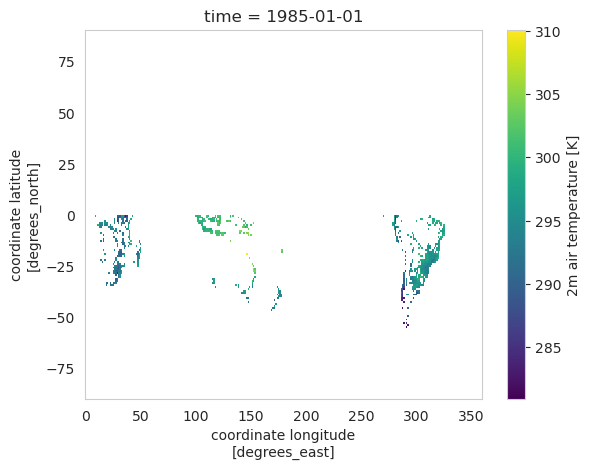

In [6]:
ds.TSA.isel(time=0).plot()


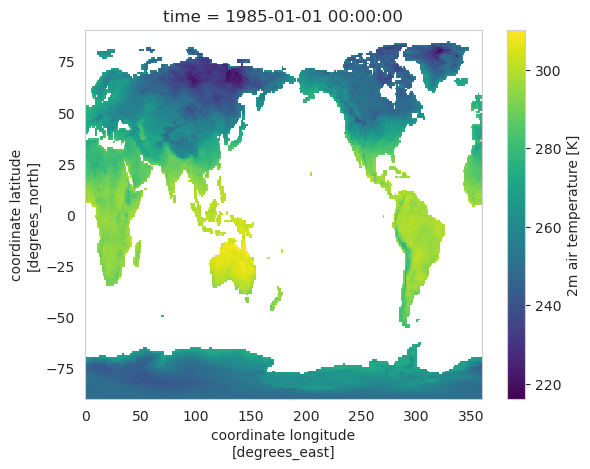

In [7]:
#read in netcdf file i.e215.I2000Clm50SpGs.hw_production.02.clm2.h2.1985-01-01-00000.nc
ds_netcdf = xr.open_dataset('/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/hourly/i.e215.I2000Clm50SpGs.hw_production.02.clm2.h2.1985-01-01-00000.nc')
ds_netcdf.TSA.isel(time=0).plot()





In [ ]:
type(ds.HW.isel(time=0).values[0][0])

In [ ]:
import xarray as xr
import numpy as np

# Function to process data in smaller chunks
def process_in_chunks(ds, chunk_size):
    # Determine the number of time steps
    num_time_steps = ds.dims['time']

    # Initialize list to hold processed chunks
    processed_chunks_hw = []
    processed_chunks_no_hw = []

    # Iterate over the dataset in chunks
    for start in range(0, num_time_steps, chunk_size):
        end = start + chunk_size
        print(f"Processing time steps {start} to {min(end, num_time_steps)}")

        # Select the chunk
        ds_chunk = ds.isel(time=slice(start, end))

        # Compute the boolean indexer for the current chunk
        hw_computed = ds_chunk.HW.compute()

        # Apply the condition and compute the chunk
        ds_hw_chunk = ds_chunk.where(hw_computed, drop=True).compute()
        ds_no_hw_chunk = ds_chunk.where(~hw_computed, drop=True).compute()

        # Append the processed chunk to the list
        processed_chunks_hw.append(ds_hw_chunk)
        processed_chunks_no_hw.append(ds_no_hw_chunk)

    # Optionally, concatenate the processed chunks back into a single dataset
    ds_hw_combined = xr.concat(processed_chunks_hw, dim='time')
    ds_no_hw_combined = xr.concat(processed_chunks_no_hw, dim='time')

    return ds_hw_combined, ds_no_hw_combined

In [0]:

# Apply the function to your dataset
ds_hw, ds_no_hw = process_in_chunks(ds, chunk_size=10)  # Adjust chunk_size as needed

# Now ds_hw and ds_no_hw contain the processed data
